# Joint Image & Text Embeddings

This example shows how SentenceTransformer can be used to map images and texts to the same vector space. 

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)



#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

c:\Users\ostas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Next, we get about 25k images from Unsplash 
img_folder = 'D:/Photos for bimodal_model/photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists('D:/Photos for bimodal_model/'+photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, 'D:/Photos for bimodal_model/'+photo_filename)
        
    #Extract all images
    with zipfile.ZipFile('D:/Photos for bimodal_model/'+photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

100%|██████████| 1.92G/1.92G [03:35<00:00, 8.92MB/s]
Extracting: 100%|██████████| 24996/24996 [00:18<00:00, 1324.24it/s]


In [ ]:
# Now, we need to compute the embeddings
# To speed things up, we distribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'D:/Photos for bimodal_model/unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/unsplash-25k-photos-embeddings.pkl', emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

100%|██████████| 51.8M/51.8M [00:09<00:00, 5.47MB/s]


Images: 24996


In [12]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))


Query:


'Computer'

oVMjj1ub5kw.jpg


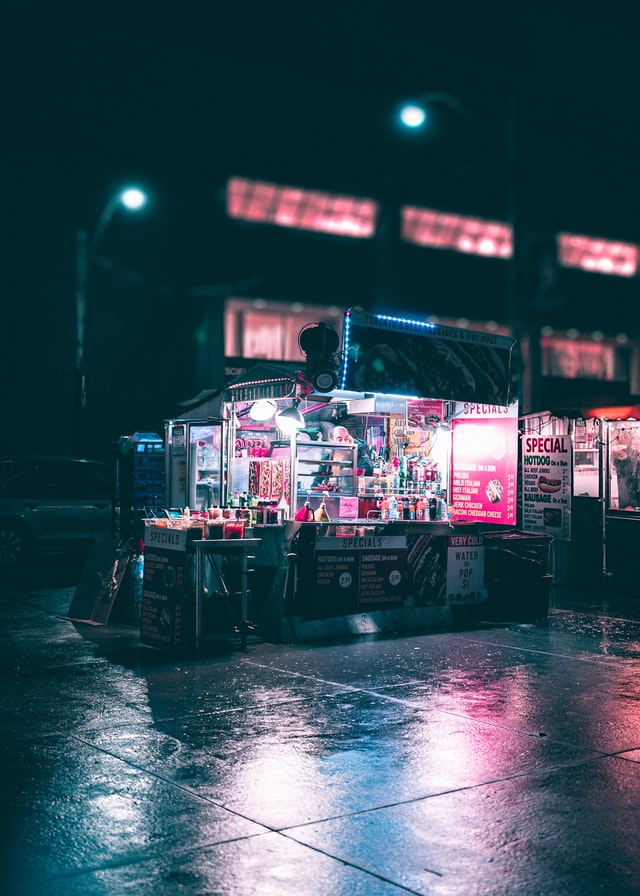

qAShc5SV83M.jpg


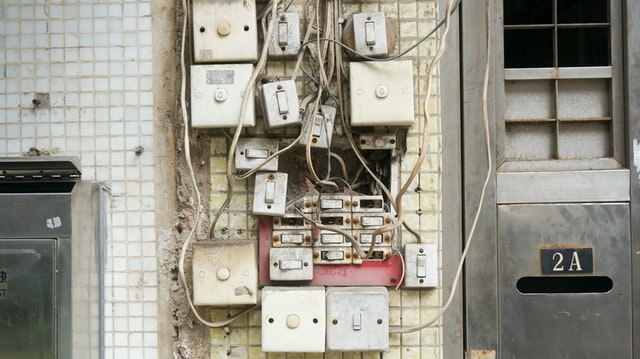

r1R_0ZNUcx0.jpg


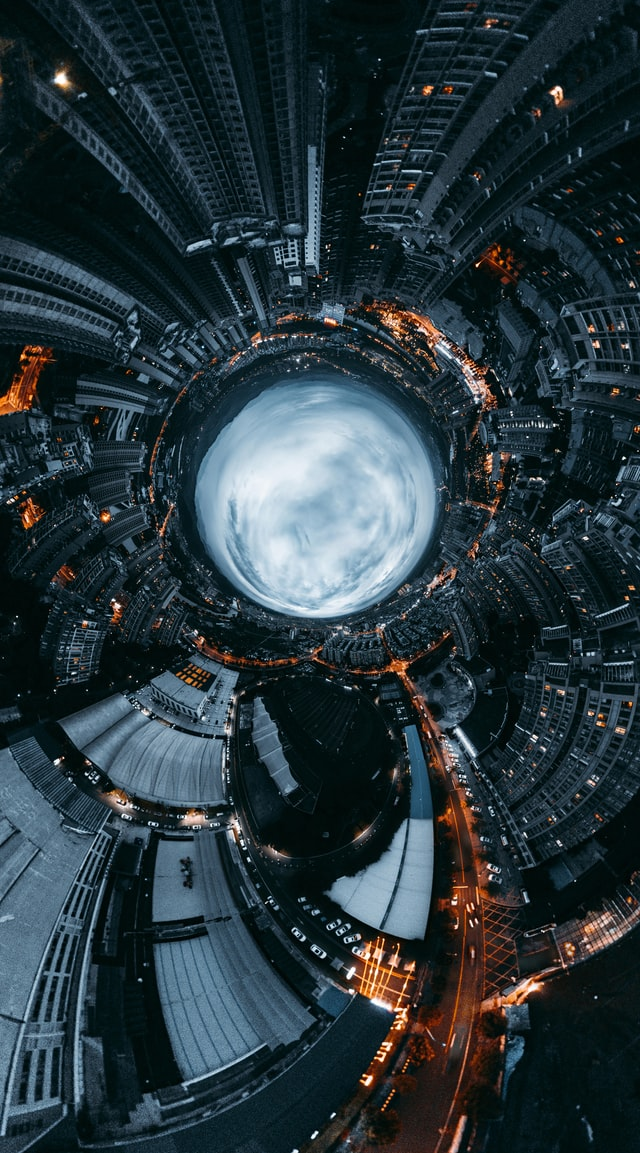

2Z8JaVIR3DA.jpg


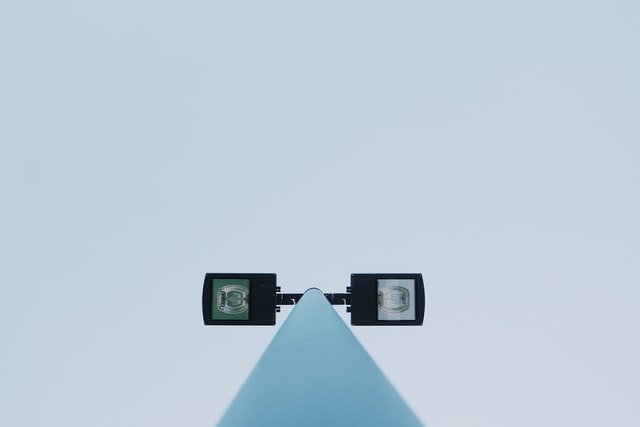

cSHyy2Ks4x4.jpg


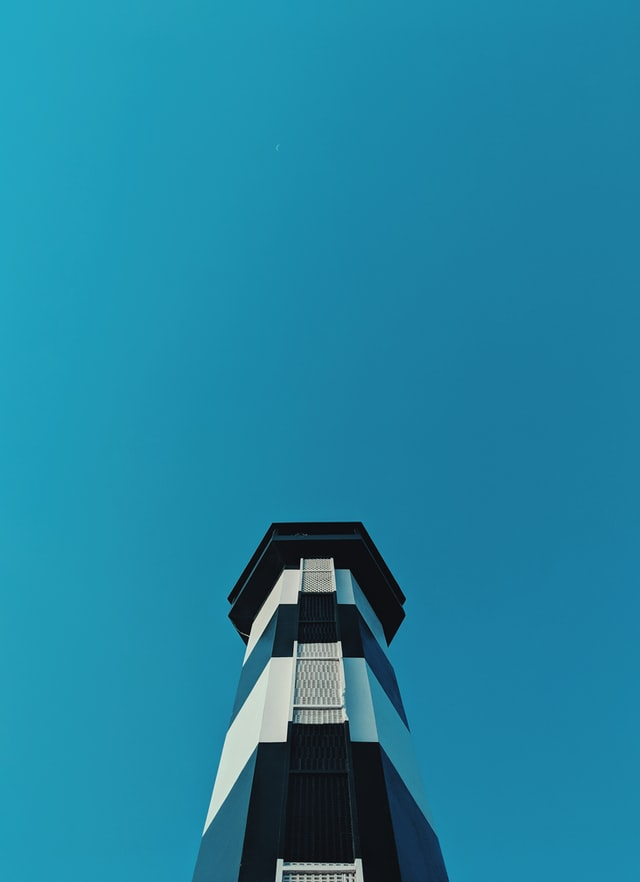

ECfXzVx-E5c.jpg


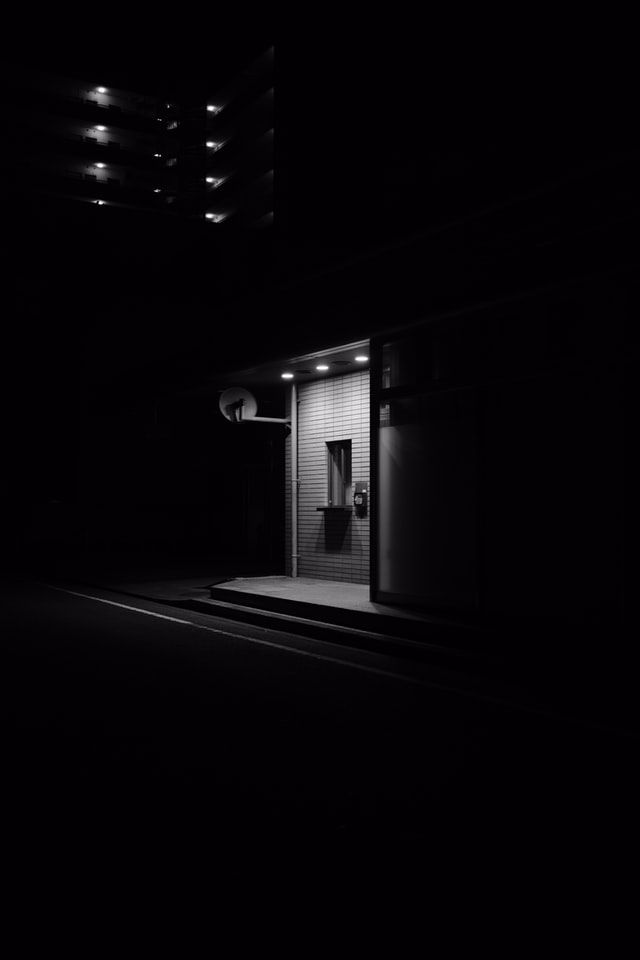

mCANW2YH-wU.jpg


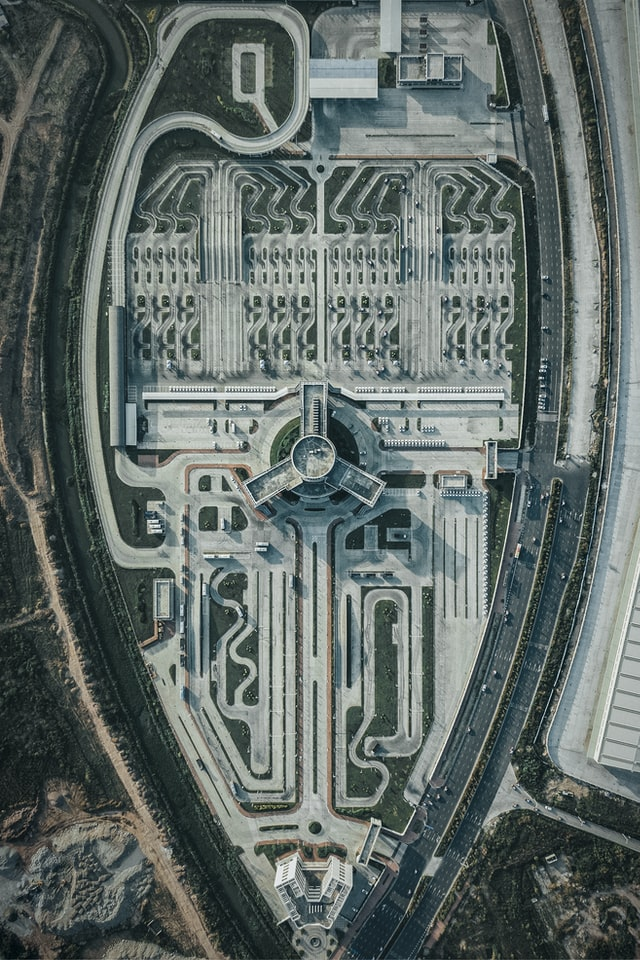

_3FAzLYaj_4.jpg


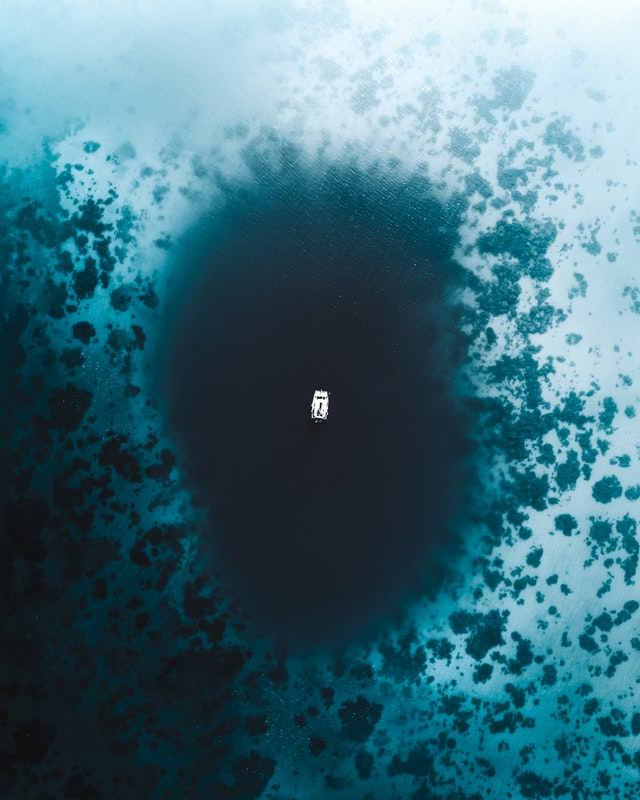

eOffmzHe2fA.jpg


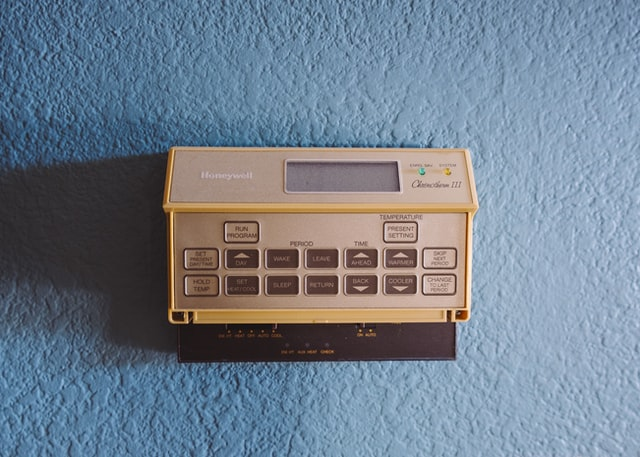

x5MPo4MeIrA.jpg


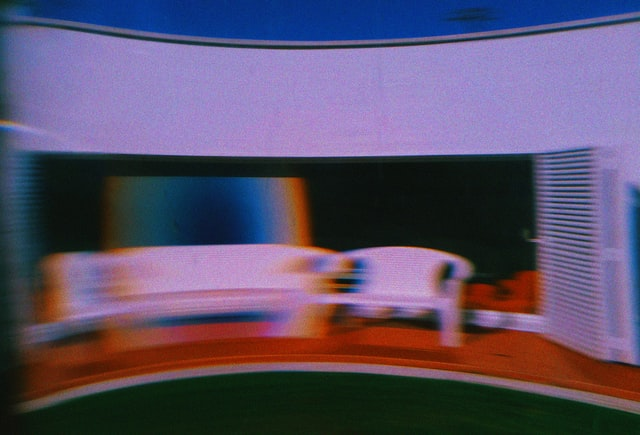

In [17]:
search('Computer', 10)

# Image-to-Image Search
You can use the method also for image-to-image search.

To achieve this, you pass `Image.open('path/to/image.jpg')` to the search method.

It will then return similar images

Query:


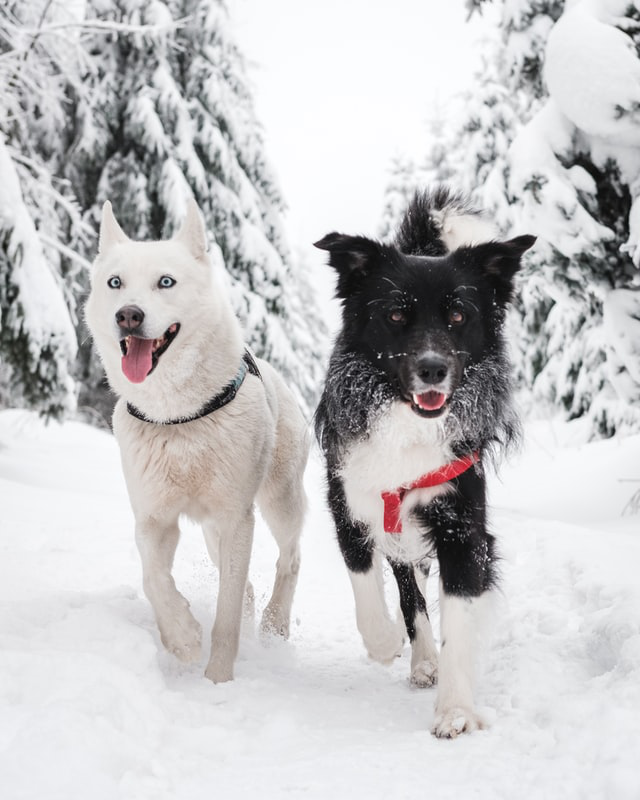

lyStEjlKNSw.jpg


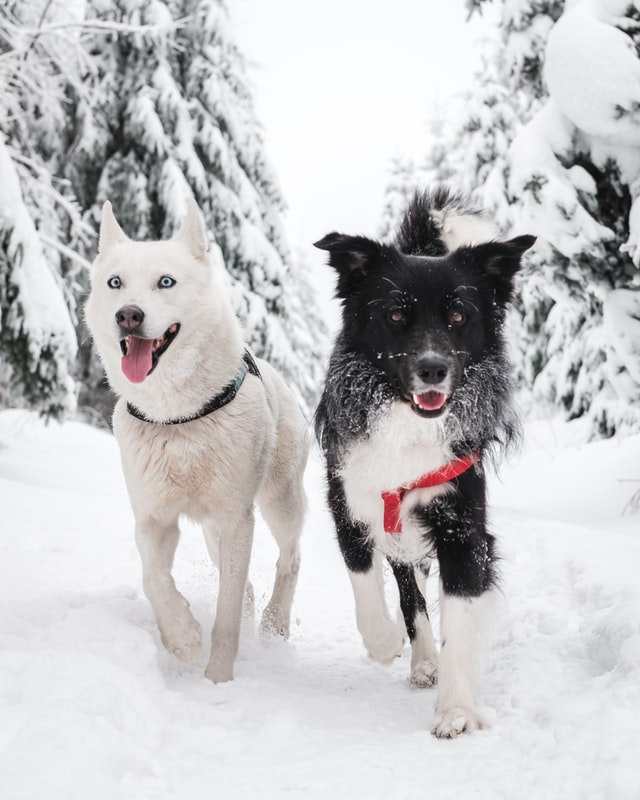

8rmYDezMIE4.jpg


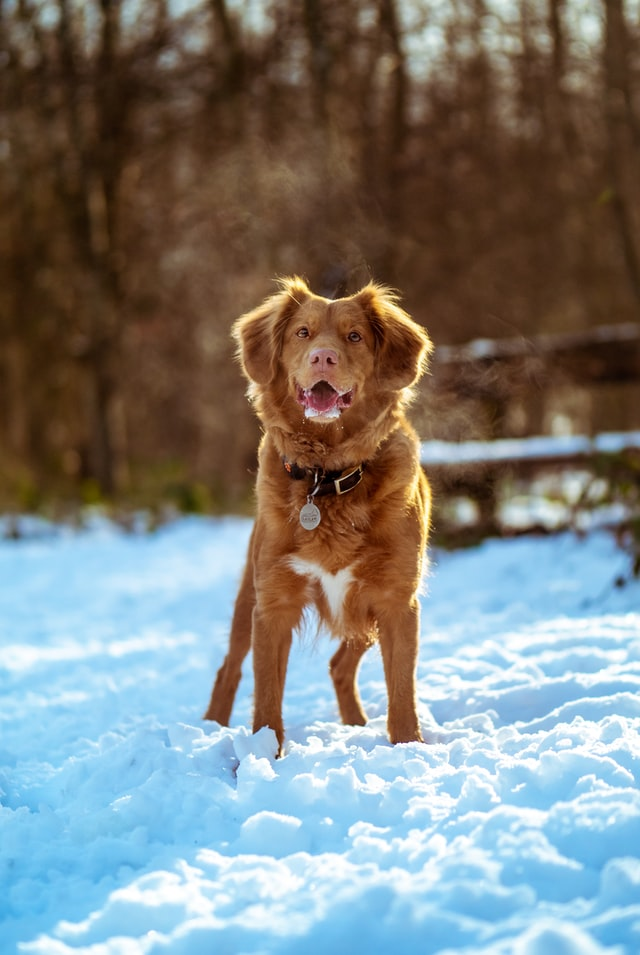

mMj5ykKvwAk.jpg


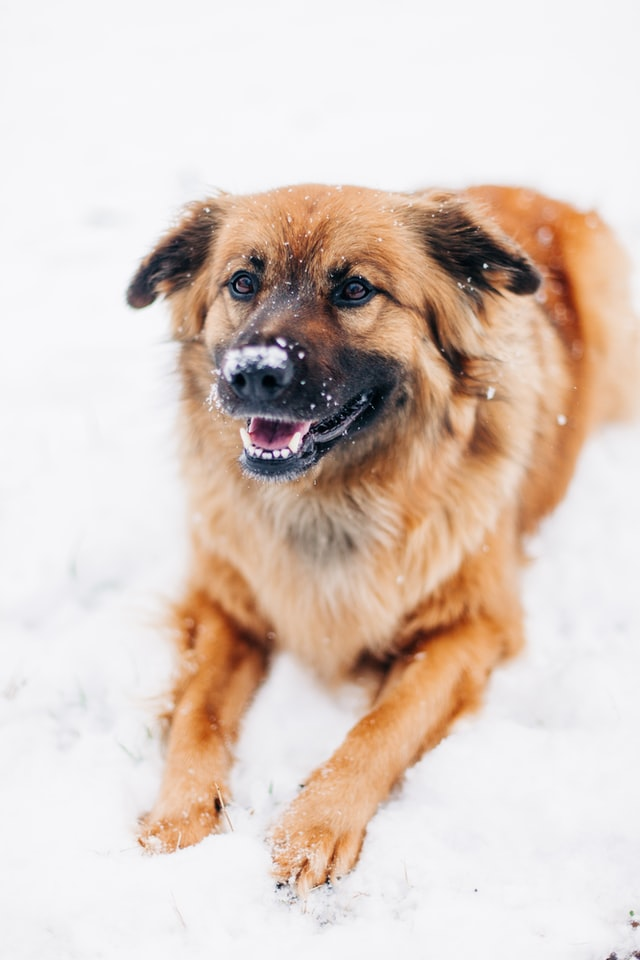

nJW1RzBXZcI.jpg


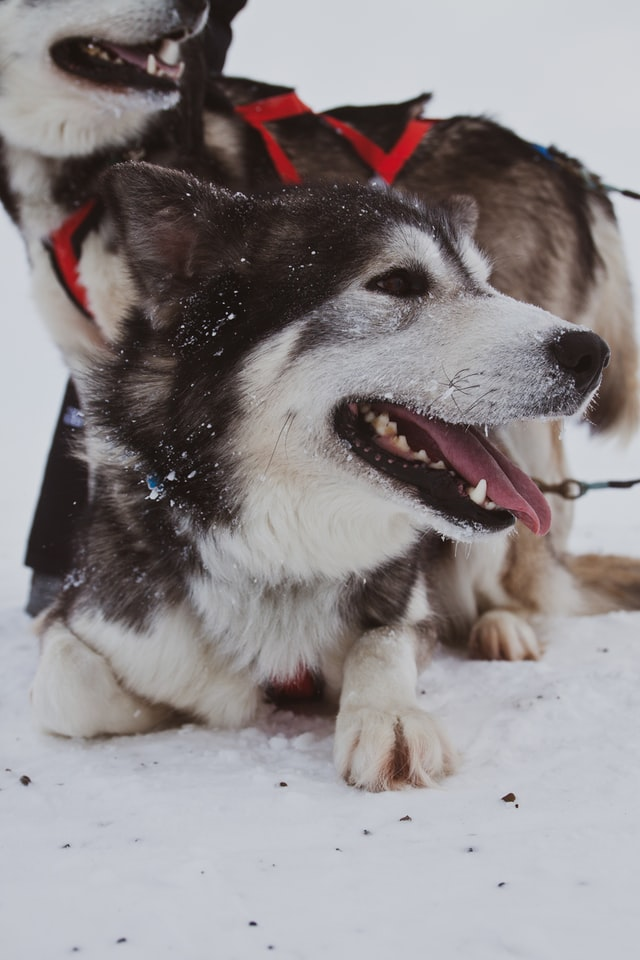

Xmo004TUzrI.jpg


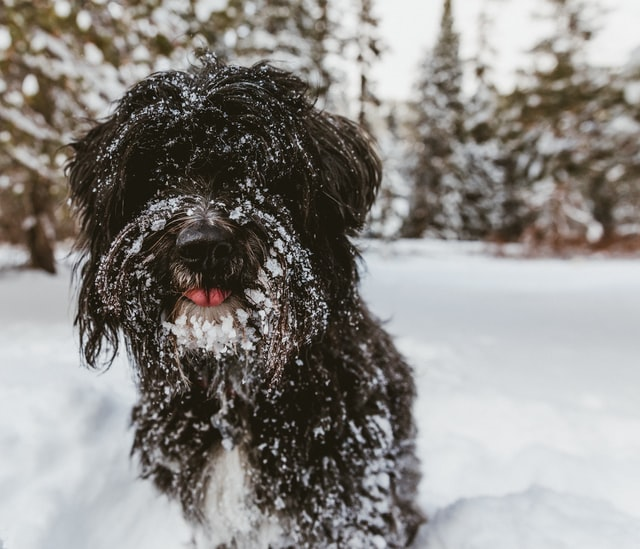

In [12]:
search(Image.open(os.path.join(img_folder, 'lyStEjlKNSw.jpg')), k=5)